In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import pandas as pd
import seaborn as sn
import time
import tensorflow as tf

In [3]:
#check if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
batch=64

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)

testset =datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
len(trainloader.dataset)

60000

In [6]:
len(testloader.dataset)

10000

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


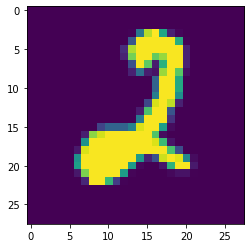

In [8]:
plt.imshow(images[0].numpy().squeeze());

In [9]:
# model = nn.Sequential(
#     nn.Linear(28*28,110),
#     nn.ReLU(),
#     nn.Linear(110,10),
#     nn.LogSoftmax(dim=1)
# )

In [10]:
class cnn_model(nn.Module):
  def __init__(self):
    super(cnn_model,self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1), 
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),

        nn.Conv2d(in_channels=12, out_channels=30, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=2, stride=1),
        nn.ReLU(),
        )
    self.linear = nn.Sequential(
         nn.Linear(in_features=30*10*10, out_features=100),          
         nn.ReLU(),
         nn.Linear(in_features=100, out_features=10),          
    )
  def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [11]:
saved_model = cnn_model()

In [12]:
torch.save(saved_model.state_dict(), 'weights_only.pth')

In [13]:
#Initialising Some metrics for comparison after multiple runs

opts = ["Adam","SGD","RMSProp","AdamW","Adagrad","Adamax"]

Best_Test_Accuracy=[]
Saturation_epochs=[]
Mean_Test_Accuracy=[]
Std_Test_Accuracy=[]
Mean_Train_Accuracy=[]
Std_Train_Accuracy=[]
Time=[]
Best_epoch=[]

For each Optimizer we are going to load the saved model and weights without initialising again and again

In [156]:
model= cnn_model()
model.load_state_dict(torch.load('weights_only.pth'))

<All keys matched successfully>

In [157]:
criterion = nn.CrossEntropyLoss()
lr=0.001

We sequentially choose a optimiser and update its results in the predeclared variables


In [158]:
import torch.optim as optim
# optimizer = optim.Adam(model.parameters(),lr=lr)
# optimizer = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(),lr=lr)
# optimizer = optim.AdamW(model.parameters(),lr=lr)
# optimizer = optim.Adagrad(model.parameters(),lr=lr)
optimizer = optim.Adamax(model.parameters(),lr=lr)

In [159]:
start=time.time()
epochs = 0
max_epochs=30
Train_Loss = []
Train_Accuracy = []
Test_Accuracy=[]

for e in range(max_epochs+1):
    epochs=e
    running_loss = 0
    total=0
    for images, labels in trainloader:

    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        pred = torch.nn.functional.softmax(output, dim=1)
        for i, p in enumerate(pred):
            if labels[i] == torch.max(p.data, 0)[1]:
                total = total + 1
        accuracy  = total*100/len(trainset)
        
        running_loss += loss.item()
        train_loss = running_loss/len(trainloader)
    else:
        Train_Loss.append(train_loss)
        Train_Accuracy.append(accuracy)
        print("Epoch {} - Training loss: {}".format(e, train_loss))
        print("Training Accuracy : {}".format(accuracy))
    correct, count = 0, 0
    y_labels=[]
    y_test=[]
    for images,labels in testloader:
      for i in range(len(labels)):
        img = images[i].view(-1,1,28,28)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        y_labels.append(pred_label)
        true_label = labels.numpy()[i]
        y_test.append(true_label)
        if(true_label == pred_label):
          correct += 1
        count += 1
    test_acc = correct*100/count
    Test_Accuracy.append(test_acc)
    print("Model Accuracy at epoch {} =".format(e),test_acc)
    print()

    if (e>=2 and abs(Test_Accuracy[-1]-Test_Accuracy[-2])<0.01):
      break

end=time.time()

Epoch 0 - Training loss: 0.2699178249211803
Training Accuracy : 92.25666666666666
Model Accuracy at epoch 0 = 97.41

Epoch 1 - Training loss: 0.08288200927733469
Training Accuracy : 97.49333333333334
Model Accuracy at epoch 1 = 98.04

Epoch 2 - Training loss: 0.05924487946036734
Training Accuracy : 98.23333333333333
Model Accuracy at epoch 2 = 98.31

Epoch 3 - Training loss: 0.048099135205562686
Training Accuracy : 98.49333333333334
Model Accuracy at epoch 3 = 98.76

Epoch 4 - Training loss: 0.04049783390671162
Training Accuracy : 98.72
Model Accuracy at epoch 4 = 98.84

Epoch 5 - Training loss: 0.035678301989756175
Training Accuracy : 98.92333333333333
Model Accuracy at epoch 5 = 98.92

Epoch 6 - Training loss: 0.03156480483388328
Training Accuracy : 99.02833333333334
Model Accuracy at epoch 6 = 99.0

Epoch 7 - Training loss: 0.027902099245321204
Training Accuracy : 99.14333333333333
Model Accuracy at epoch 7 = 98.99

Epoch 8 - Training loss: 0.024430008935658925
Training Accuracy : 9

In [160]:
time_taken = end-start
print(time_taken/epochs)

47.298637284172905


In [161]:
mean_train_accuracy = sum(Train_Accuracy) / len(Train_Accuracy)
variance_train_accuracy = sum([((x - mean_train_accuracy) ** 2) for x in Train_Accuracy]) / len(Train_Accuracy)
std_train_accuracy = variance_train_accuracy**0.5
print(mean_train_accuracy)
print(std_train_accuracy)

98.08766666666666
2.0135989339157563


In [162]:
mean_test_accuracy = sum(Test_Accuracy) / len(Test_Accuracy)
variance_test_accuracy = sum([((x - mean_train_accuracy) ** 2) for x in Test_Accuracy]) / len(Test_Accuracy)
std_test_accuracy = variance_test_accuracy**0.5
print(mean_test_accuracy)
print(std_test_accuracy)

98.60799999999999
0.7214172009162121


In [163]:
best_test_accuracy = max(Test_Accuracy)
print(best_test_accuracy)
print(Test_Accuracy.index(best_test_accuracy))
sat_epochs = epochs
print(sat_epochs)

99.0
6
9


In [164]:
def view(img):
    fig, (ax1) = plt.subplots(figsize=(2,3))
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    plt.tight_layout()

Predicted Digit = 7
Predicted Digit = 2
Predicted Digit = 1
Predicted Digit = 0


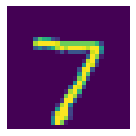

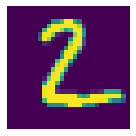

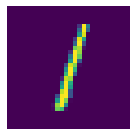

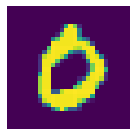

In [165]:
images, labels = next(iter(testloader))
for i in range (0,4):
  img = images[i].view(-1,1,28,28)
  with torch.no_grad():
      logps = model(img)

  ps = torch.exp(logps)
  probab = list(ps.numpy()[0])
  print("Predicted Digit =", probab.index(max(probab)))
  view(img)

In [166]:
cm=tf.math.confusion_matrix(labels=y_test , predictions=y_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 976,    0,    0,    0,    0,    0,    0,    2,    2,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    1, 1019,    1,    1,    0,    0,    7,    0,    0],
       [   1,    0,    0, 1002,    0,    2,    0,    5,    0,    0],
       [   0,    0,    0,    0,  979,    0,    1,    0,    0,    2],
       [   2,    0,    0,   10,    0,  874,    1,    2,    1,    2],
       [   5,    3,    0,    0,    4,    6,  939,    0,    1,    0],
       [   0,    1,    3,    0,    0,    0,    0, 1022,    1,    1],
       [   6,    0,    4,    1,    1,    2,    0,    2,  955,    3],
       [   2,    2,    1,    1,    6,    2,    0,    4,    2,  989]],
      dtype=int32)>

Text(69.0, 0.5, 'Actual')

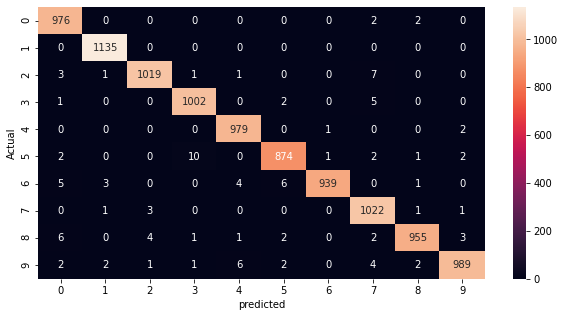

In [167]:
plt.figure(figsize=(10,5))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel("predicted")
plt.ylabel("Actual")

Text(0, 0.5, 'Loss')

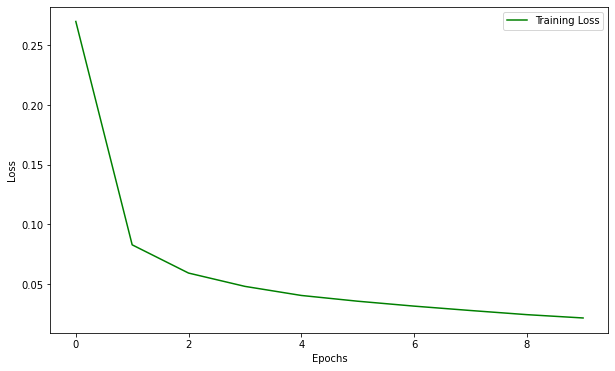

In [168]:
num_epochs=[i for i in range(epochs+1)]
fig = plt.figure(figsize=[10,6]) 
plt.plot(num_epochs,Train_Loss,'g-',label='Training Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

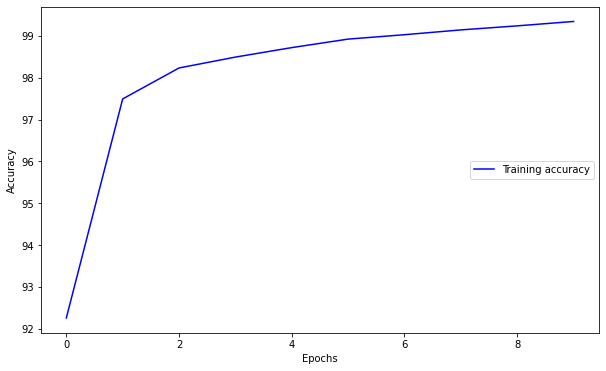

In [169]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(num_epochs,Train_Accuracy,'b-',label='Training accuracy') 
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

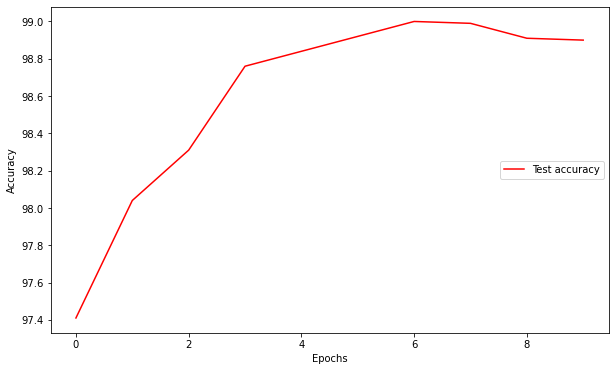

In [170]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(num_epochs,Test_Accuracy,'r-',label='Test accuracy') 
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [171]:
Best_Test_Accuracy.append(best_test_accuracy)
Saturation_epochs.append(sat_epochs)
Mean_Test_Accuracy.append(mean_test_accuracy)
Std_Test_Accuracy.append(std_test_accuracy)
Mean_Train_Accuracy.append(mean_train_accuracy)
Std_Train_Accuracy.append(std_train_accuracy)
Time.append(time_taken/epochs)
Best_epoch.append(Test_Accuracy.index(best_test_accuracy))

After Completing all the runs for different optimizers we plot the comparison graphs

Text(0, 0.5, 'Accuracy')

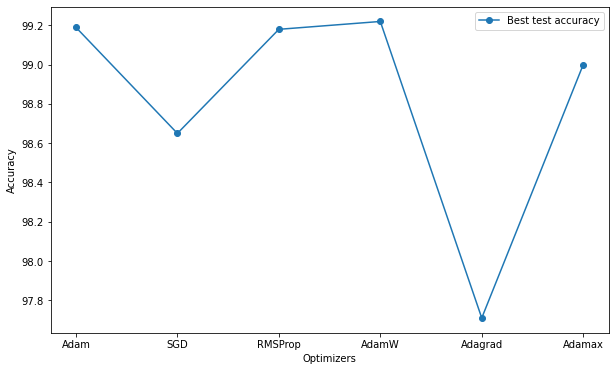

In [182]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Best_Test_Accuracy,label='Best test accuracy',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Time (in sec)')

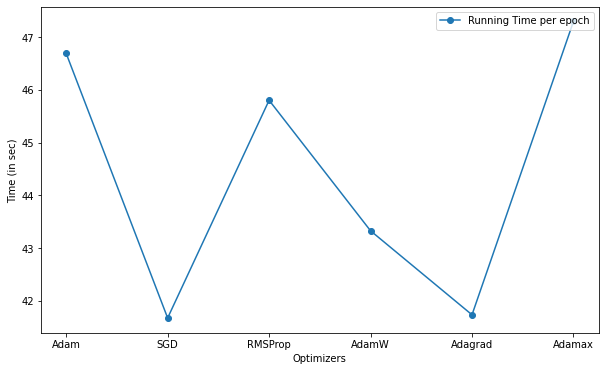

In [183]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Time,label='Running Time per epoch',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Time (in sec)')

Text(0, 0.5, 'Epochs')

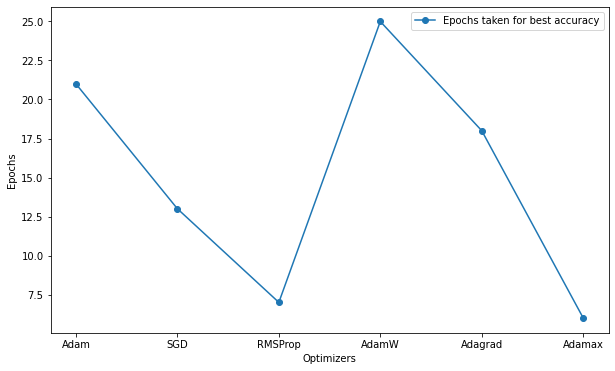

In [184]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Best_epoch,label='Epochs taken for best accuracy',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Epochs')

Text(0, 0.5, 'Epochs')

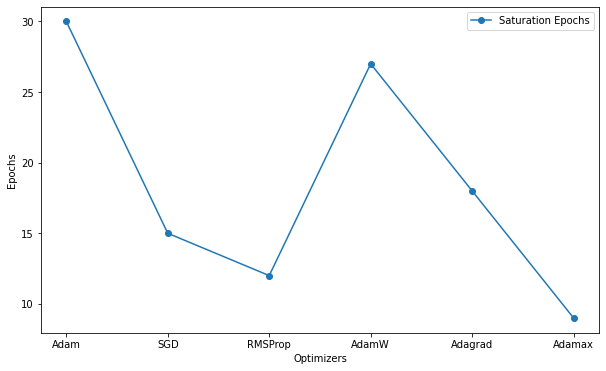

In [185]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Saturation_epochs,label='Saturation Epochs',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Epochs')

Text(0, 0.5, 'Accuracy')

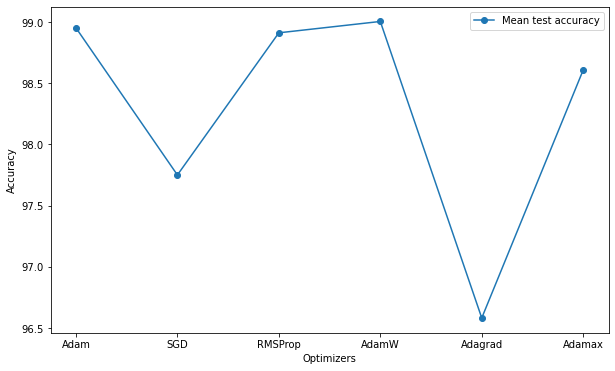

In [186]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Mean_Test_Accuracy,label='Mean test accuracy',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

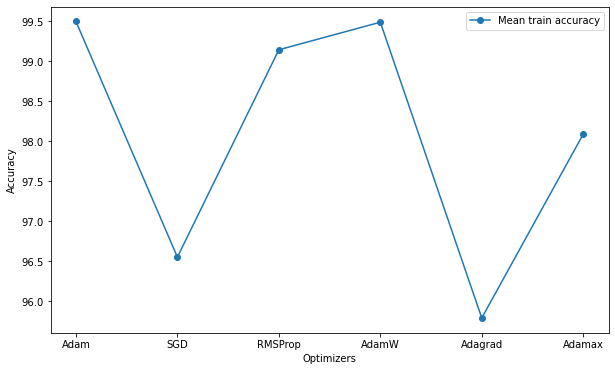

In [187]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Mean_Train_Accuracy,label='Mean train accuracy',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Std')

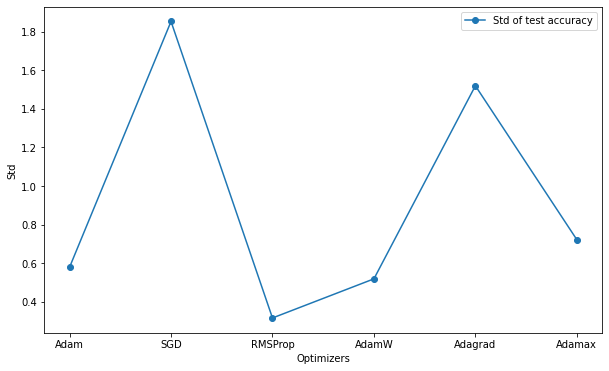

In [188]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Std_Test_Accuracy,label='Std of test accuracy',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Std')

Text(0, 0.5, 'Std')

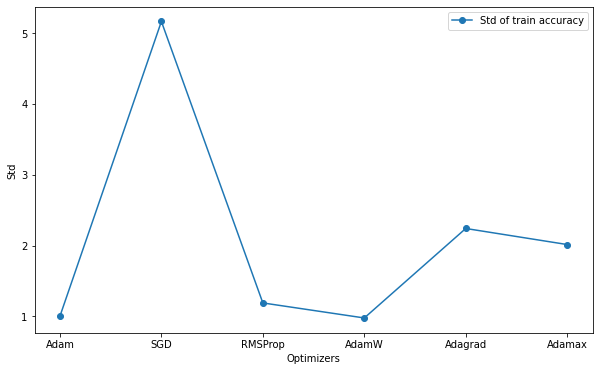

In [196]:
fig = plt.figure(figsize=[10,6]) 
plt.plot(opts,Std_Train_Accuracy,label='Std of train accuracy',marker='o') 
plt.legend(loc='upper right')
plt.xlabel('Optimizers')
plt.ylabel('Std')

In [ ]:
# torch.save(model, './mnist.pt') 